Evaluation of vanilla LightFM models trained on 5 core of Amazon Clothes dataset with hyperparameters:,
loss: warp
learning_schedule: 'adadelta'
no_components: 100
Models were initialized with embeddings produced by word2vec.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from utils import analyse_metrics, analyse_embeddings

In [2]:
tqdm.pandas()
THREADS = 8

In [3]:
epochs = [1, 5, 25, 100, 250, 500, 1000]
models = [pd.read_pickle(f'/pio/scratch/1/i313924/data/lightfm_data/model_{epochs}_epochs_word2vec.pkl') for epochs in epochs]
train_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_interactions.npz')
test_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_test_interactions.npz')
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/5_core_dataset.pkl')

In [4]:
categories = pd.read_json(
    '/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)
abx_path = '/pio/scratch/1/recommender_systems/interim/ABX_tests/5_core.json'

In [5]:
item_ids = list(dataset.mapping()[2].keys())
women_ids = categories[(categories.category_1 == "Women") & (categories.asin.isin(item_ids))].asin.values
men_ids = categories[(categories.category_1 == "Men") & (categories.asin.isin(item_ids))].asin.values

PCA prepared
Working on model from epoch 1
Working on model from epoch 5
Working on model from epoch 25
Working on model from epoch 100
Working on model from epoch 250
Working on model from epoch 500
Working on model from epoch 1000


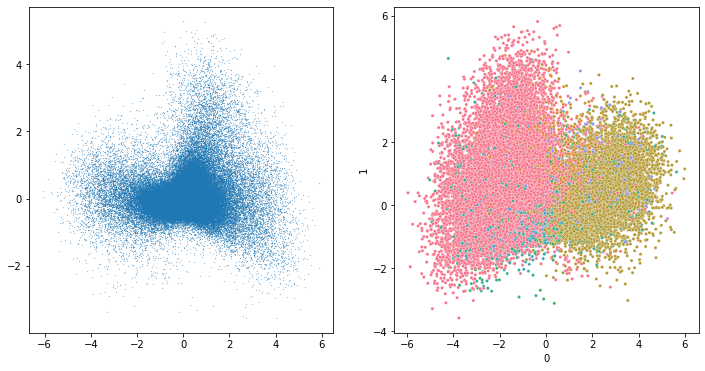

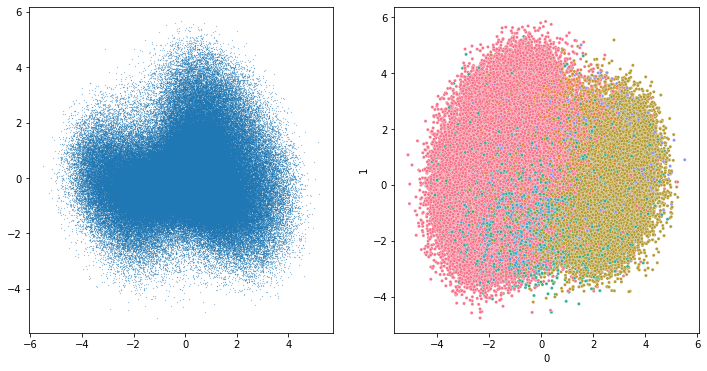

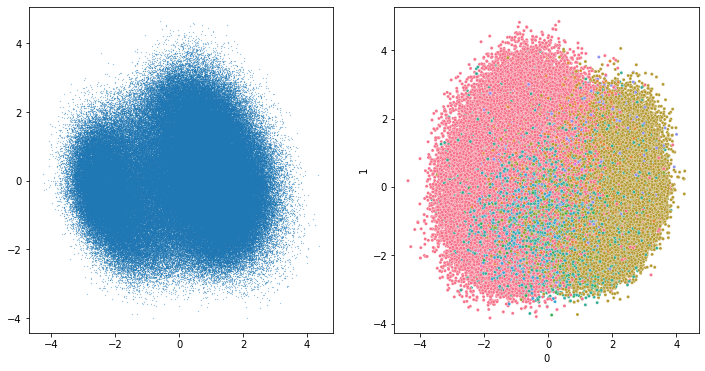

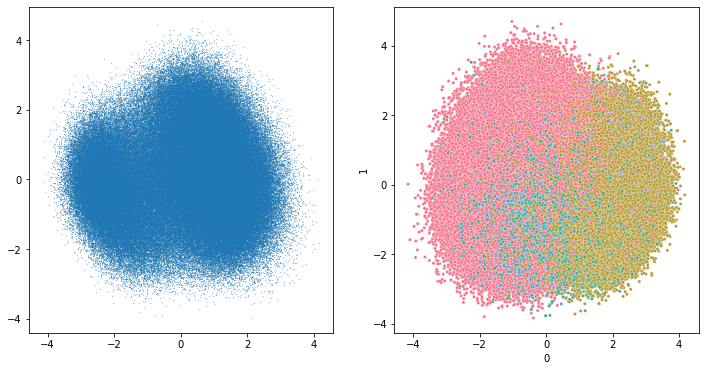

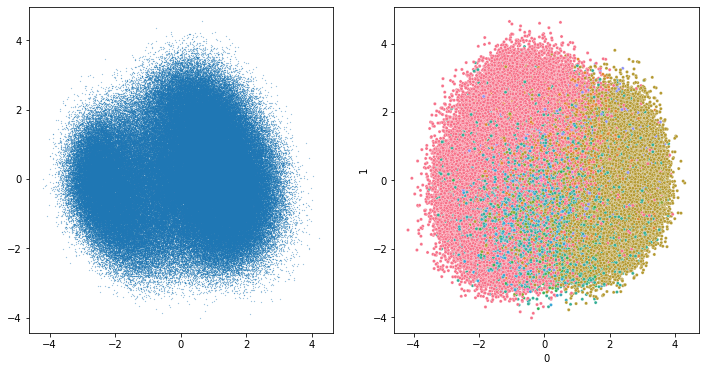

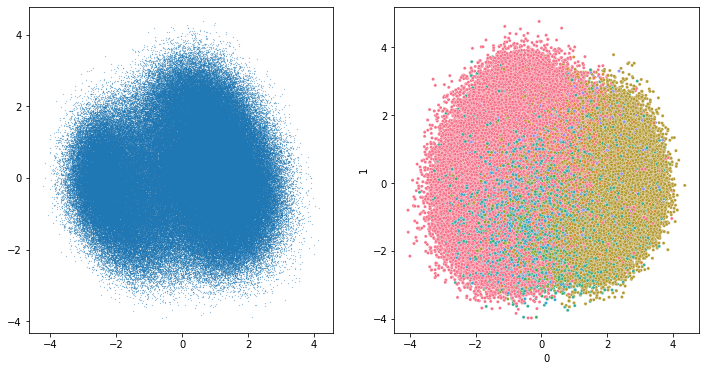

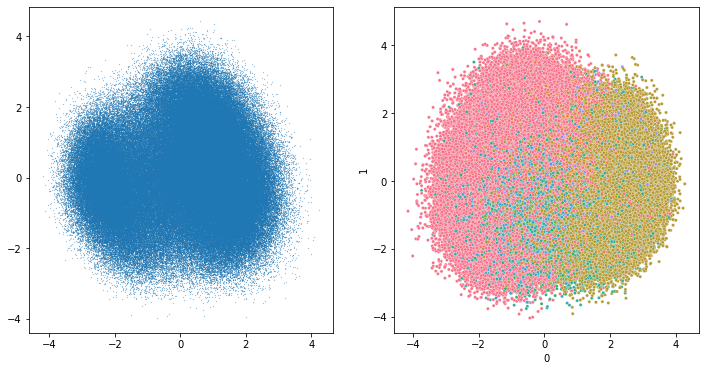

In [6]:
e, c, women_means, men_means, item_pca = analyse_embeddings(epochs, models, dataset, categories, abx_path, women_ids, men_ids)

<AxesSubplot:xlabel='0', ylabel='1'>

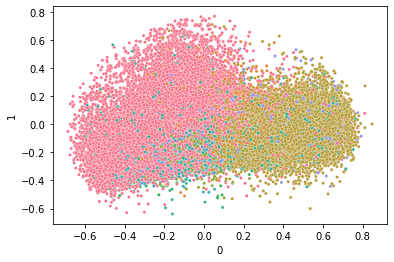

In [7]:
word2vec_embeddings = pd.read_parquet('/pio/scratch/1/recommender_systems/processed/word2vec/amazon-clothes/5-core/item_item_embeddings.parquet')
transformed = pd.DataFrame(item_pca.transform(word2vec_embeddings))
transformed.index = word2vec_embeddings.index
transformed = transformed.join(categories.set_index('asin'))
transformed.columns = ['0', '1', 'category_1', 'category_2']
sns.scatterplot(x='0', y='1', data=transformed, hue='category_1', s=10, legend=False)

<AxesSubplot:xlabel='0', ylabel='1'>

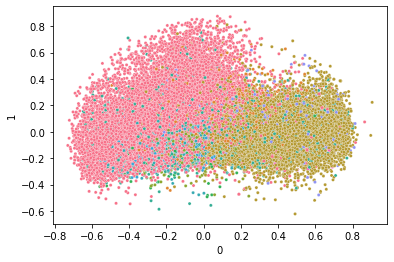

In [10]:
t2 = pd.DataFrame(PCA(n_components=2).fit_transform(word2vec_embeddings))
t2.index = word2vec_embeddings.index
t2 = t2.join(categories.set_index('asin'))
t2.columns = ['0', '1', 'category_1', 'category_2']
sns.scatterplot(x='0', y='1', data=t2, hue='category_1', s=10, legend=False)

Eucl dist


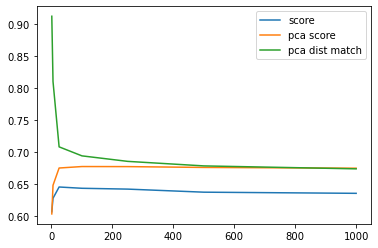

Cos dist


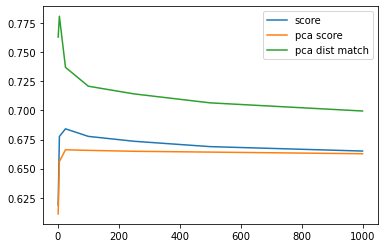

In [11]:
print("Eucl dist")
plt.plot(np.tile(epochs, (3, 1)).T, e)
plt.legend(["score", "pca score", "pca dist match"])
plt.show()
print("Cos dist")
plt.plot(np.tile(epochs, (3, 1)).T, c)
plt.legend(["score", "pca score", "pca dist match"])
plt.show()

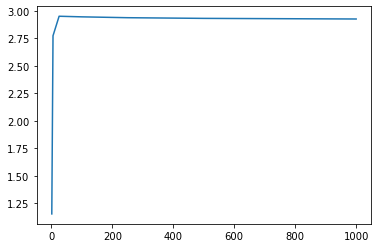

In [12]:
plt.plot(epochs, np.sqrt(((np.array(men_means) - np.array(women_means))**2).sum(axis=1)))

In [13]:
reduced_men_means = item_pca.transform(men_means)
reduced_women_means = item_pca.transform(women_means)

In [14]:
reduced_men_means

array([[ 0.81409622, -0.1017444 ],
       [ 1.91358084, -0.24397933],
       [ 1.97741237, -0.19547829],
       [ 1.97036162, -0.18143861],
       [ 1.96415658, -0.17539495],
       [ 1.95957254, -0.17114836],
       [ 1.95530326, -0.16757003]])

In [15]:
reduced_women_means

array([[-0.32994812, -0.00145264],
       [-0.79600046,  0.24346107],
       [-0.88712527,  0.35693444],
       [-0.88772366,  0.36742275],
       [-0.88574772,  0.3712755 ],
       [-0.88391032,  0.37369952],
       [-0.88214844,  0.37596892]])

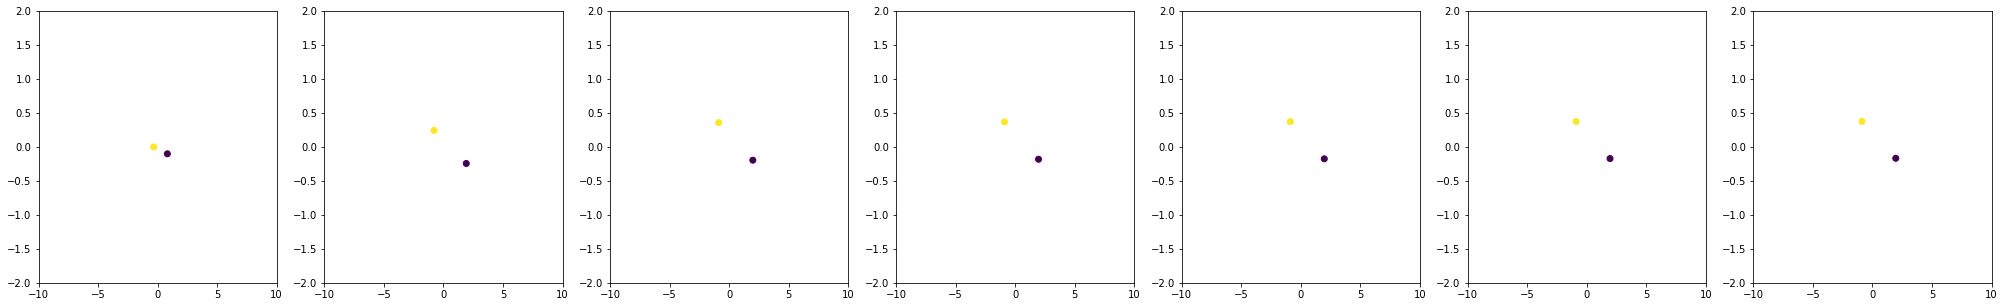

In [16]:
figure, axis = plt.subplots(1, len(epochs), figsize=(len(epochs)*5,5))
for i in range(len(epochs)):
    axis[i].scatter([reduced_men_means[i][0], reduced_women_means[i][0]], [reduced_men_means[i][1], reduced_women_means[i][1]], c=[1, 2])
    axis[i].set_xlim([-10, 10])
    axis[i].set_ylim([-2, 2])

In [ ]:
tqdm.pandas()
test_hit_rate_scores, test_recall_scores, test_precision_scores = analyse_metrics(models, train_interactions, test_interactions, dataset)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
test_recall_scores

In [ ]:
test_precision_scores

In [ ]:
test_hit_rate_scores